# **ASHRAE-Great Energy Predictor III**

### Mount The Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc

### Load The data

In [ ]:
train_df = pd.read_feather('/gdrive/My Drive/case_study_data/train_df_dash.ftr')
test_df = pd.read_feather('/gdrive/My Drive/case_study_data/test_df_dash.ftr')

In [ ]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,dayofweek,month,dayofyear,day,year,latitude,solarHour,solarDec,horizsolar,is_holiday,relative_humidity,sqaure_footage
0,46,0,3.994141,0,11,9.109375,3.912109,25.000000,6.0,20.000000,-0.17395,0.0,4.0,1.0,1.0,1.0,2016.0,28.53125,-180.0,-23.03125,0.0,0,73.8125,35.62500
1,74,0,3.785156,0,8,12.867188,3.912109,25.000000,6.0,20.000000,-0.17395,0.0,4.0,1.0,1.0,1.0,2016.0,28.53125,-180.0,-23.03125,0.0,0,73.8125,50.34375
2,93,0,3.978516,0,6,10.414062,3.912109,25.000000,6.0,20.000000,-0.17395,0.0,4.0,1.0,1.0,1.0,2016.0,28.53125,-180.0,-23.03125,0.0,0,73.8125,40.75000
3,105,0,3.191406,1,0,10.835938,3.912109,3.800781,0.0,2.400391,0.00000,0.0,4.0,1.0,1.0,1.0,2016.0,50.90625,-180.0,-23.03125,0.0,0,90.5000,42.40625
4,106,0,0.318115,1,0,8.585938,3.912109,3.800781,0.0,2.400391,0.00000,0.0,4.0,1.0,1.0,1.0,2016.0,50.90625,-180.0,-23.03125,0.0,0,90.5000,33.59375


In [ ]:
test_df.head()

,row_id,building_id,meter,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,dayofweek,month,dayofyear,day,year,latitude,solarHour,solarDec,horizsolar,is_holiday,relative_humidity,sqaure_footage
0,0,0,0,0,0,8.914062,3.849609,17.796875,4.000000,11.703125,0.282715,0.0,6.0,1.0,1.0,1.0,2017.0,28.53125,-180.0,-23.03125,0.0,0,67.50,34.31250
1,41614356,1393,0,15,1,11.929688,3.849609,-6.480469,2.132812,-11.085938,-1.000000,0.0,6.0,1.0,1.0,1.0,2017.0,40.71875,-180.0,-23.03125,0.0,0,69.75,45.93750
2,41614355,1392,2,15,1,11.242188,3.849609,-6.480469,2.132812,-11.085938,-1.000000,0.0,6.0,1.0,1.0,1.0,2017.0,40.71875,-180.0,-23.03125,0.0,0,69.75,43.28125
3,41614354,1392,0,15,1,11.242188,3.849609,-6.480469,2.132812,-11.085938,-1.000000,0.0,6.0,1.0,1.0,1.0,2017.0,40.71875,-180.0,-23.03125,0.0,0,69.75,43.28125
4,41614353,1391,2,15,1,11.140625,3.849609,-6.480469,2.132812,-11.085938,-1.000000,0.0,6.0,1.0,1.0,1.0,2017.0,40.71875,-180.0,-23.03125,0.0,0,69.75,42.87500


In [ ]:
train_df.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'hour', 'dayofweek', 'month',
       'dayofyear', 'day', 'year', 'latitude', 'solarHour', 'solarDec',
       'horizsolar', 'is_holiday', 'relative_humidity', 'sqaure_footage'],
      dtype='object')

KFOLD LightGBM

In [ ]:
#https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08
categorical_features = ["building_id",
     "site_id",
     "meter",
     "primary_use",
     "hour",
     'dayofyear',
     'day',
     'hour',
     'month',
     'is_holiday',
     'dayofweek']

In [ ]:

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 16,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
    'min_data_in_leaf' : 6000,
}

y = train_df.meter_reading
X = train_df.drop("meter_reading", axis=1)

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(X):
    train_features = X.loc[train_index]
    train_target = y.loc[train_index]
    
    test_features = X.loc[test_index]
    test_target = y.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.13823	valid_1's rmse: 1.17834
[50]	training's rmse: 0.929178	valid_1's rmse: 0.997681
[75]	training's rmse: 0.811032	valid_1's rmse: 0.887296
[100]	training's rmse: 0.736821	valid_1's rmse: 0.822694
[125]	training's rmse: 0.694075	valid_1's rmse: 0.78227
[150]	training's rmse: 0.660069	valid_1's rmse: 0.755445
[175]	training's rmse: 0.638188	valid_1's rmse: 0.735989
[200]	training's rmse: 0.620155	valid_1's rmse: 0.719604
[225]	training's rmse: 0.608258	valid_1's rmse: 0.708741
[250]	training's rmse: 0.596526	valid_1's rmse: 0.703345
[275]	training's rmse: 0.587979	valid_1's rmse: 0.692646
[300]	training's rmse: 0.580163	valid_1's rmse: 0.692384
[325]	training's rmse: 0.57131	valid_1's rmse: 0.687138
[350]	training's rmse: 0.566088	valid_1's rmse: 0.684258
[375]	training's rmse: 0.559003	valid_1's rmse: 0.680253
[400]	training's rmse: 0.553402	valid_1's rmse: 0.676177
[425]	training's rmse: 0.548913	v

In [ ]:
fimp_df = pd.DataFrame()
fimp_df["feature"] = X.columns.values
fimp_df["importance"] = models[0].feature_importance()
fimp_df["half"] = 1
fimp_df.sort_values(by='importance', ascending=False)
fimp_df.sort_values(by='importance', ascending=False).feature[:-10].values

array(['building_id', 'meter', 'dayofyear', 'hour', 'square_feet',
       'month', 'site_id', 'air_temperature', 'primary_use',
       'dew_temperature', 'latitude', 'sqaure_footage', 'solarHour'],
      dtype=object)

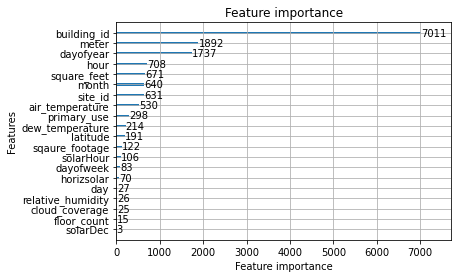

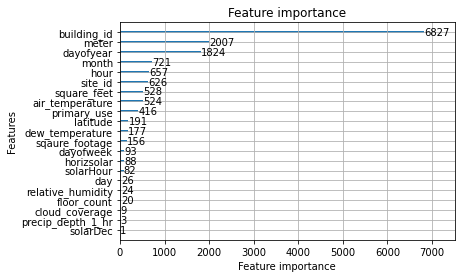

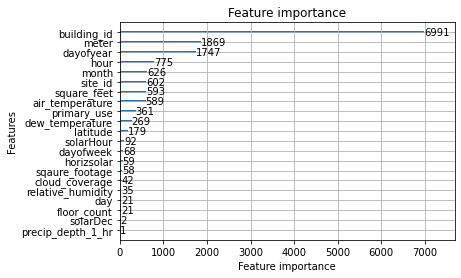

In [ ]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

both of my features squared_footage and relative_humidity features are come in the features importnaces that is really good and i also think is_holiday feature is important but it is not  and also seen from the above plots the raw features are the most important features 

In [ ]:
from tqdm import tqdm_notebook as tqdm

def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

iterations 42
predicting 0-th model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



predicting 1-th model



predicting 2-th model


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


100

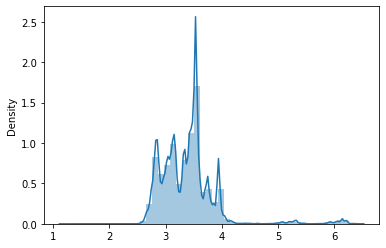

In [ ]:
gc.collect()

y_test = pred(test_df, models)

sns.distplot(y_test)

gc.collect()

In [ ]:
y_test

array([4.43669771, 3.41433041, 2.95688871, ..., 3.08288128, 3.61483897,
       3.04478546])

In [ ]:
submission = pd.read_csv('/gdrive/My Drive/case_study_data/sample_submission.csv')

In [ ]:
submission.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
submission.shape

(41697600, 2)

In [ ]:
submission["meter_reading"] = np.expm1(y_test)

In [ ]:
submission.head()

,row_id,meter_reading
0,0,82.988248
1,1,26.272448
2,2,13.977656
3,3,26.272448
4,4,13.977656


In [ ]:
submission.to_csv('/gdrive/My Drive/case_study_data/submission_lgbm_gbdt.csv', index=False)

In [ ]:
sample_submission = pd.read_csv('/gdrive/My Drive/case_study_data/submission_lgbm_gbdt.csv')

In [ ]:
sample_submission.shape

(41697600, 2)

In [ ]:
sample_submission.head()

,row_id,meter_reading
0,0,82.988248
1,1,26.272448
2,2,13.977656
3,3,26.272448
4,4,13.977656


### Summary
Both of my features squared_footage and relative_humidity features are come in the features importnaces that is really good and i also think is_holiday feature is important but it is not  and also seen from the above plots the raw features are the most important features 

### Refrences
1. https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08
2. why light gbm is the first choice https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

In [ ]:
from prettytable import PrettyTable
summary = PrettyTable()


summary.field_names = ["Model", "RMSE"]
summary.add_row(["LightGBM GBDT",.646105])
print(summary)

+---------------+----------+
|     Model     |   RMSE   |
+---------------+----------+
| LightGBM GBDT | 0.646105 |
+---------------+----------+


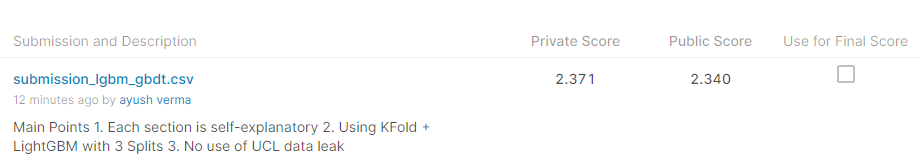

In [ ]:
from IPython.display import Image
Image(filename='LGBM1.PNG')